<a href="https://colab.research.google.com/github/KemasRaihan/FaceDetector/blob/main/face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Detection
---





# 1. Introduction

**1.1 Image Classification**

Image classification is an essential task in computer vision, where an image is analysed and assigned to a specific class or category based on its features. One of the significant applications of image classification is detecting human faces in images, which has many practical applications, such as security, surveillance, and photography.

**1.2 Project Plan**

In this project, we will use various machine learning algorithms to detect human faces in images. We will explore several different algorithms which are widely used in image classification. During the evaluation, we will examine which models are the most effective at predicting the images using a confusion matrix and classification reports. We will also use these results to analyse whether these models have been overfitted or under fitted.

**1.3 Libraries Used**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage import data,color,feature
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#Visualisation Tools
import seaborn as sns
import pandas as pd
import cv2
from yellowbrick.contrib.classifier import DecisionViz
!python -m pip install opencv-python
%matplotlib inline

#Scaling dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#hog feature extraction
from itertools import chain
from skimage.io import imread_collection
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

#feature analysis
from sklearn.decomposition import PCA

#algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**1.4 Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Data Analysis/Pre-Processing

**2.1 Positive Patches**

The postive patches will be images that contain human faces.

In [ ]:
filepath = '/content/drive/MyDrive/Sheffield_Hallam_University/Second_Year/AI_and_ML_1/Assignment/positive_patches.npy'
pos_patches  = np.load(filepath)

**2.2 Negative Patches**

The negative patches will be images that do not contain human faces.

In [ ]:
filepath = '/content/drive/MyDrive/Sheffield_Hallam_University/Second_Year/AI_and_ML_1/Assignment/negative_patches.npy'
neg_patches  = np.load(filepath)

**2.3 Dataset Size and Shape**

In [ ]:
pos_patches.shape

(13233, 2914)

In [ ]:
neg_patches.shape

(30000, 2914)

Our dataset consists of 43233 patches. Only 13233 contains positive patches (30.6% of the entire dataset).

**2.4 Display First 30 Positive Patches Images**

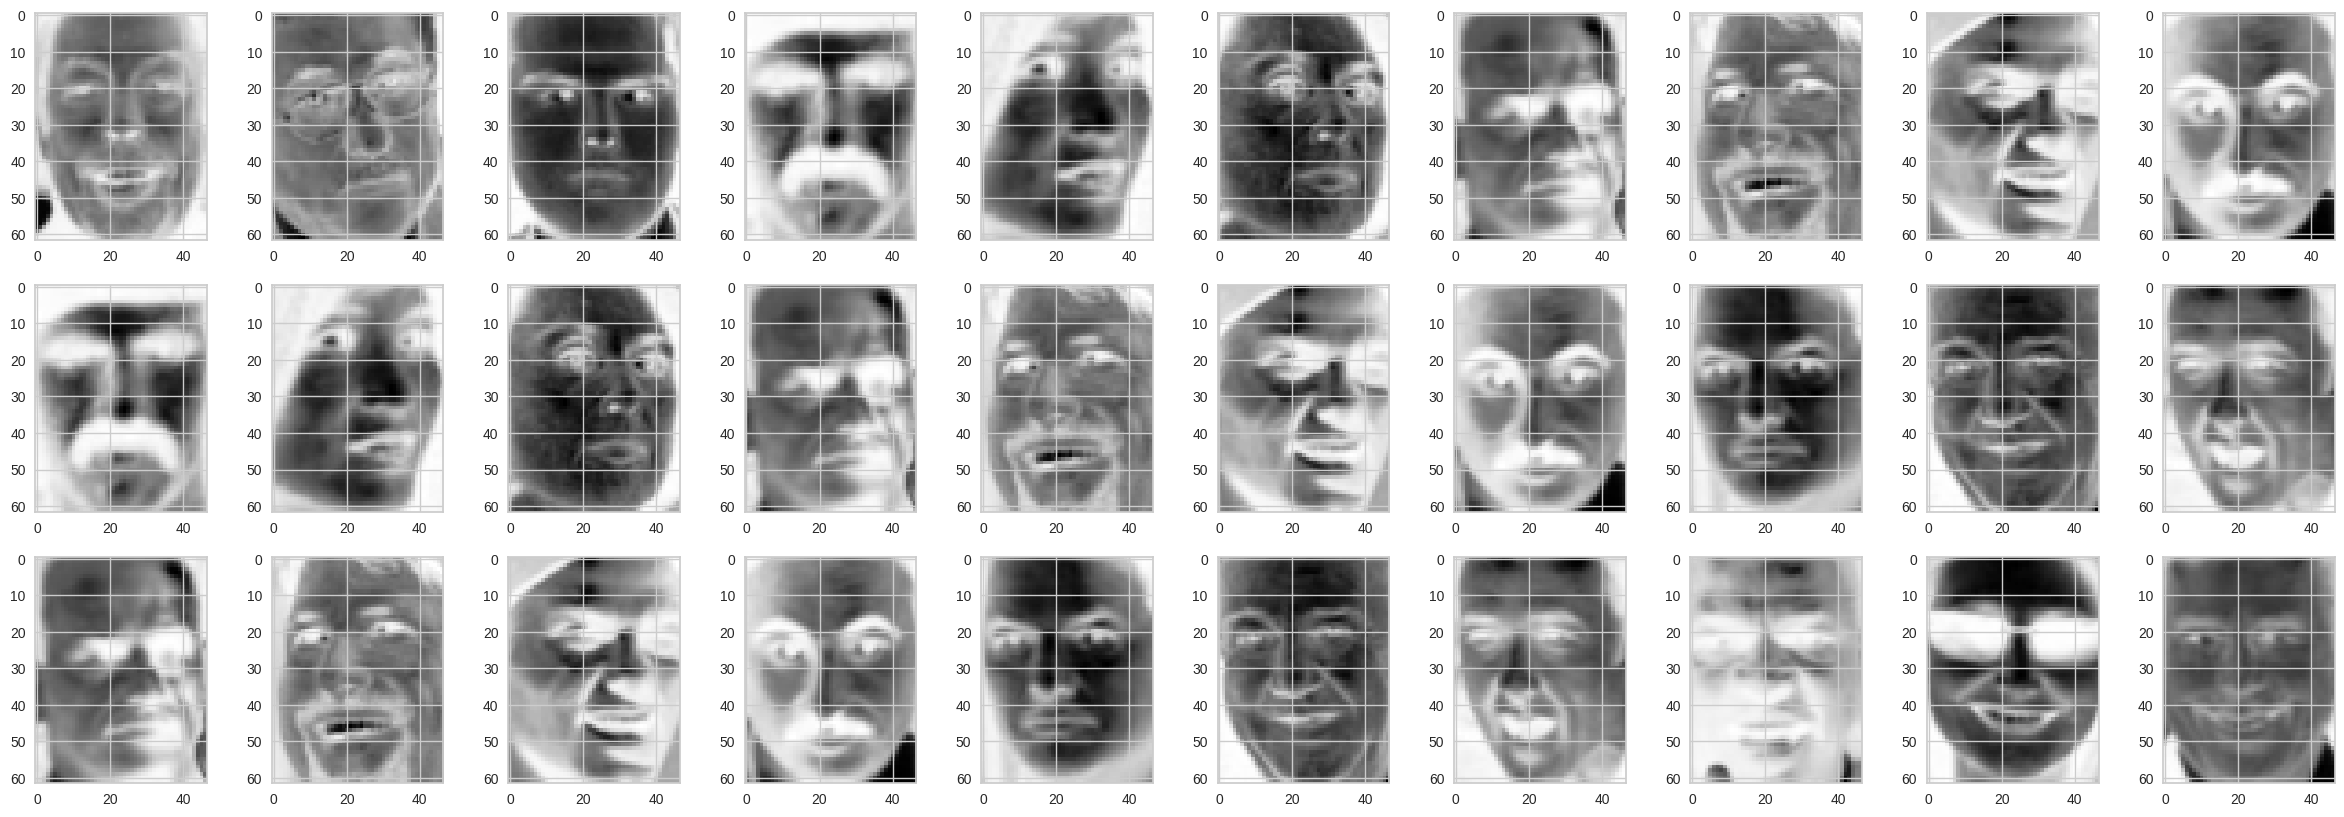

In [ ]:
fig, axes = plt.subplots(3,10, figsize=(30,10))
for i in range(3):
  for j in range(10):
    axes[i][j].imshow(pos_patches[3*i+j].reshape(62,47))

**2.5 Display First 30 Negative Patches Images**

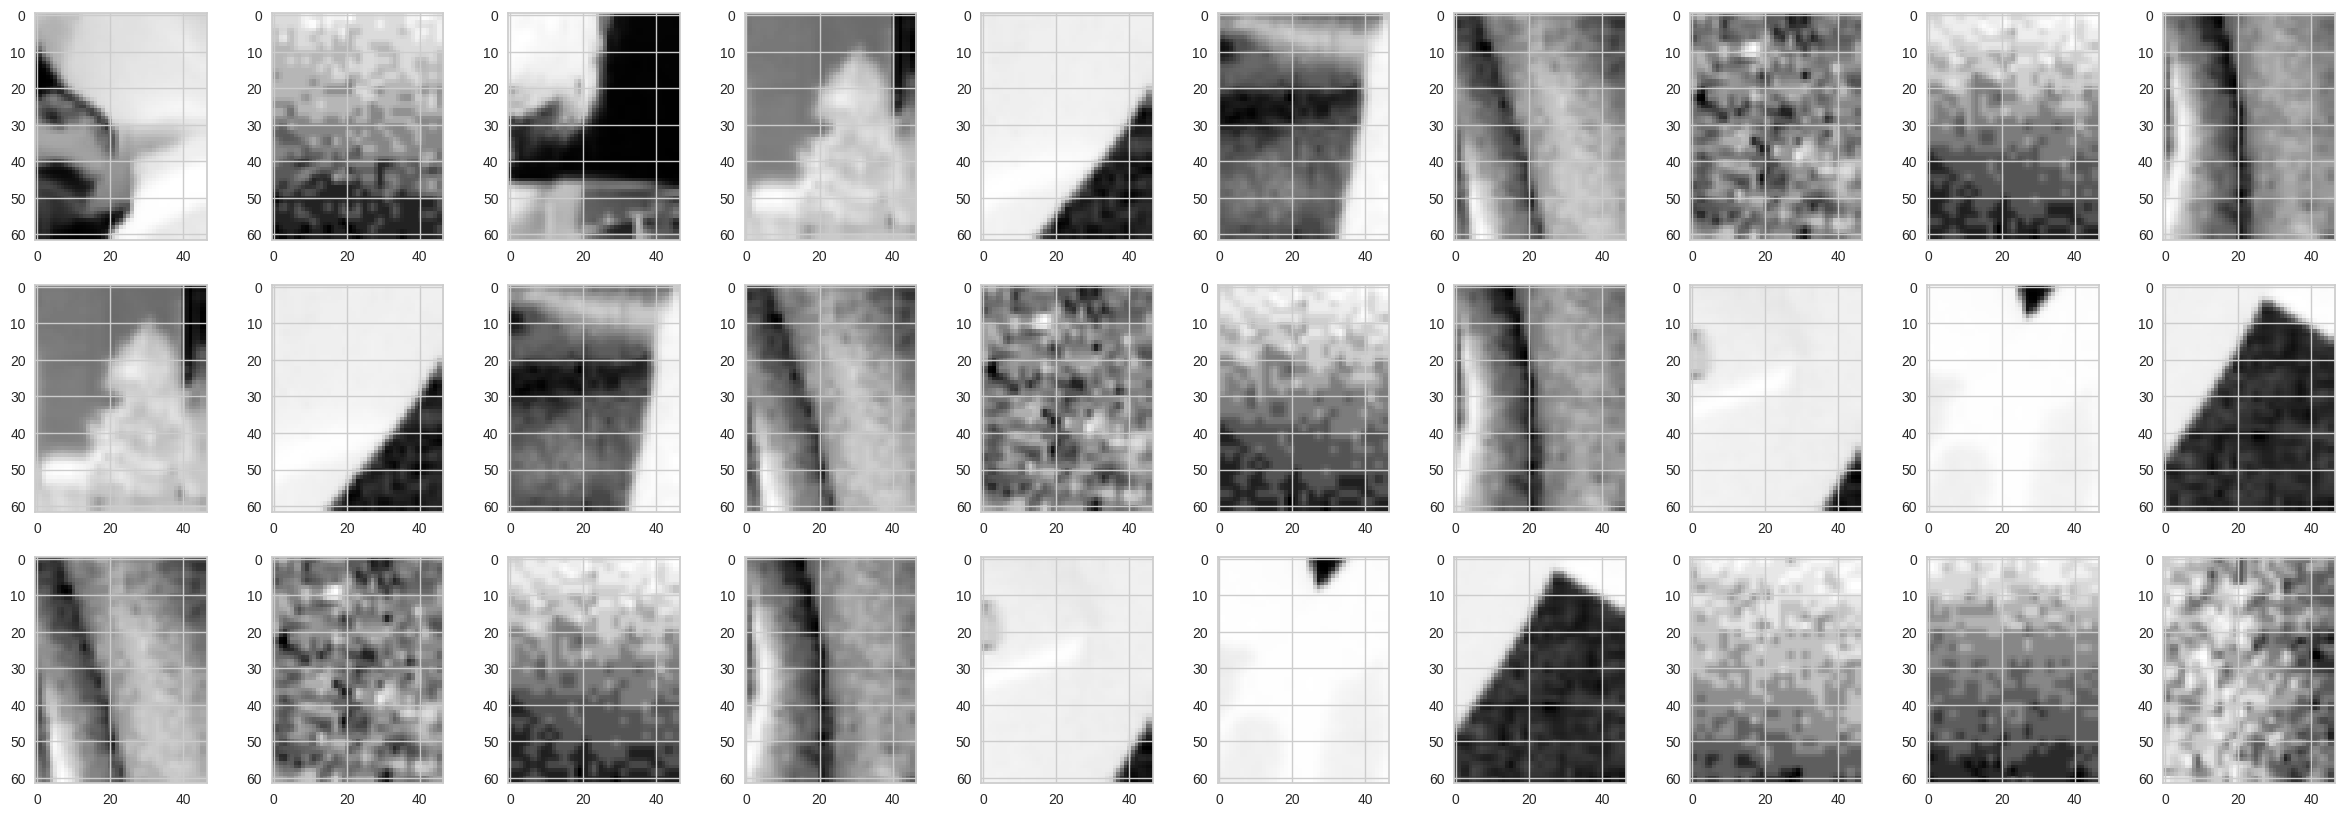

In [ ]:
fig, axes = plt.subplots(3,10, figsize=(30,10))
for i in range(3):
  for j in range(10):
    axes[i][j].imshow(neg_patches[3*i+j].reshape(62,47))

**2.6 Data Distribution**

In [ ]:
# Calculate mean and standard deviation of pixel values for positive patches
mean_pos = np.mean(pos_patches.flatten())
std_pos = np.std(pos_patches.flatten())

print("Mean Pixel Value Of Positive Patches:", mean_pos)
print("Standard Deviation:", std_pos)

Mean Pixel Value Of Positive Patches: 127.98199
Standard Deviation: 47.50035


In [ ]:
# Calculate mean and standard deviation of pixel values for negative patches
mean_neg = np.mean(neg_patches.flatten())
std_neg = np.std(neg_patches.flatten())

print("Mean Pixel Value Of Negative Patches:", mean_neg)
print("Standard deviation:", std_neg)

Mean Pixel Value Of Negative Patches: 78.30981196652715
Standard deviation: 75.20276354386087


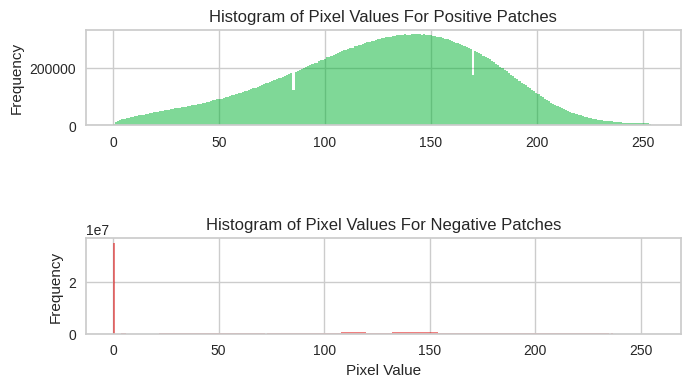

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(8,5))
fig.tight_layout(pad=5.0)

#Define histogram for positive patches
axes[0].hist(pos_patches.flatten(), bins=256, range=(0, 255), color='#00b330', alpha=0.5)
axes[0].title.set_text('Histogram of Pixel Values For Positive Patches')
axes[0].set_ylabel('Frequency')

#Define histogram for negative patches
axes[1].hist(neg_patches.flatten(), bins=256, range=(0, 256), color='#e00202', alpha=0.5)
axes[1].title.set_text('Histogram of Pixel Values For Negative Patches')
axes[1].set_xlabel('Pixel Value')
axes[1].set_ylabel('Frequency')

plt.show()

**Figure 2.1** - From the histograms, the pixel values for the positive patches are evenly distributed approximately uniformly between 0 and 255, indicating that the intensity of the colours is consistent for similar data points.This is expected since the shape of human faces are similar. In contrast, the pixel values for the negative have a higher standard deviation and the pixel values for the negative patches are extremely positively skewed suggesting that dark colours are much more prevalent in the images.

**2.8 Reshape the patches**

Here we are reshaping our patches to be 62x47 patches in order to be displayed as images.

In [ ]:
pos_images = np.array([img.reshape(62,47) for img in pos_patches])
neg_images = np.array([img.reshape(62,47) for img in neg_patches])

## 3. Feature Analysis



**3.1 Feature Space**

To extract our features, we have used the Sci-kit Learn Image Processing package to extract the 2D HoG features and use them as the feature space for the machine learning algorithms. Our feature space (X) will be the 2D HOG features of both the positive and negative samples. This will be stored in a numpy array for use.

In [ ]:
X = np.array([hog(img, multichannel=False) for img in chain(pos_images,neg_images)])

<ipython-input-8-cf841c6c5d96>:1: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  X = np.array([hog(img, multichannel=False) for img in chain(pos_images,neg_images)])


In [ ]:
X.shape

(43233, 1215)

**3.2 Labels**

The labels (y) for our data will be:

*   0 - for images that do not contain human faces.
*   1 - for images that contains the human faces.


Since we know the number of positive samples in our feature space, we can simply label the `len(pos_images) `of `X` as 1.

In [ ]:
y=np.zeros(len(X))
y[0:len(pos_images)]=1

**3.3 Normalise The Dataset**

Normalising the dataset will enable each feature to contribute to the analysis equally. As we can see from figure 2.1, the extremely positive skewed data of our negative pathces will degrade the model’s ability (especially regression based models) to describe typical cases as it has to deal with rare cases on  the extreme values. In this case, the algorithm will predict better on data points with lower values, compared to those with higher values (Cheryl 2020). We will normalise the dataset using the `MinMaxScaler`.




In [ ]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

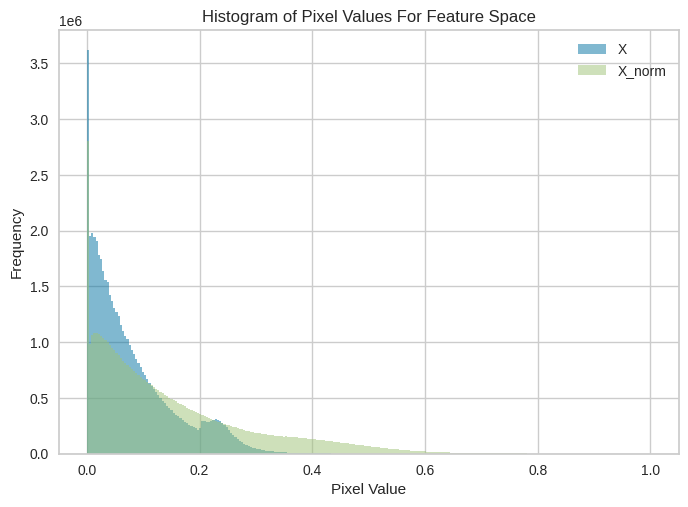

In [ ]:
#Define histogram for feature
plt.hist(X.flatten(), bins=256, alpha=0.5, label='X')
plt.hist(X_norm.flatten(), bins=256, alpha=0.5, label='X_norm')
plt.legend()
plt.title('Histogram of Pixel Values For Feature Space')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

While the normalization of our data may not be perfect, it will still enhance the accuracy of our models.

**3.4 Principal Component Analysis (PCA)**

Our feature space contains 1215 features. Principal component analysis will reduce our feature space, which contains 1215 features, into just two dimensions (principal components) allowing us to visulise our data while retaining most of the information in the large set.

In [ ]:
pca=PCA(n_components=2)
X_PCA = pca.fit_transform(X_norm)

<ipython-input-12-a1203f33aea3>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
<ipython-input-12-a1203f33aea3>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_map = plt.cm.get_cmap('jet', 10)


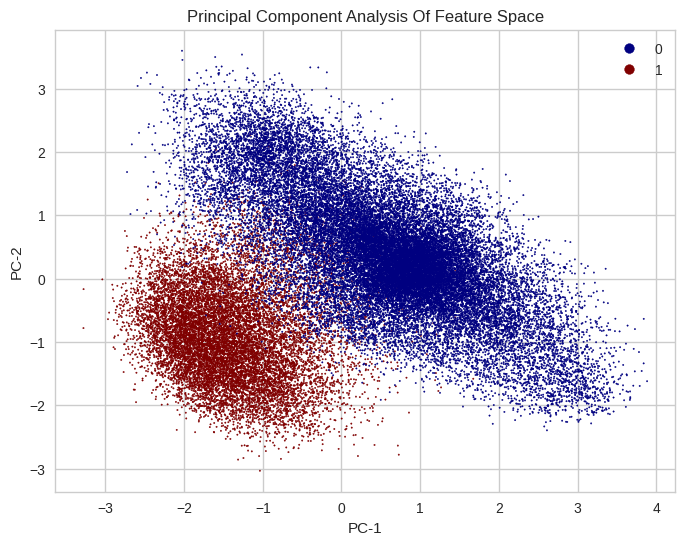

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8,6))
c_map = plt.cm.get_cmap('jet', 10)
scatter = plt.scatter(X_PCA[:,0], X_PCA[:,1], s=1, cmap=c_map, c=y)
plt.title('Principal Component Analysis Of Feature Space')
plt.legend(*scatter.legend_elements())
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.show()

As we examine the scatter plot, we can see that there is some blue points that are close to the classification  there is a minimal overlap between the positive patches and negative patches, indicating that prediction should be relatively simple.

## 4. Machine Learning

**4.1 Split Data For Training, Validation and Testing**

We will split out datasets into three seperate datasets:

* **Training**: used for training our machine learning models.
* **Validation**: for the unbiased evaluation of a model fitted on the training dataset while tuning model hyperparameters.
* **Testing**: the unbiased evaluation of a final model fitted on the training dataset.

In [ ]:
# Firstly split them into the training dataset and the rest as remaining dataset for validation and testing
X_train, X_rem, y_train, y_rem = train_test_split(X_norm, y, train_size=0.8, random_state=42)

# Split the remaining dataset for validation and testing
X_validation, X_test, y_validation, y_test = train_test_split(X_rem, y_rem, train_size=0.5)

**4.2 Machine Learning Algorithms**

According to Gong (2016), the six best algorithms for image classification are: K-Nearest Neighbors, Support Vector Machines, Logistic Regression, Decision Tree Classifier, Random Forest and Naive Bayes. However, to save time, we will only train our models using the first four algorithms:


*   **K-Nearest Neighbors (KNN):** a simple and effective classification algorithm that classifies a test point based on the classes of its K nearest neighbours in the training set. In our case, we will use the HOG features to compute the Euclidean distance between the test image and the training images and assign the test image to the class that has the most neighbours.

*   **Support Vector Machines (SVM):** a powerful classification algorithm that finds a hyperplane that separates the data into different classes with the maximum margin. In our case, we will use the HOG features to train an SVM classifier that separates the face images from the images that do not contain human faces.

*   **Logistic Regression:** a linear classification algorithm that models the probability of the target class using a logistic function. In our case, we will use the HOG features to train a logistic regression classifier that predicts the probability of a test image containing a face or no face.

*  **Decision Tree Classifier:** a non-parametric classification algorithm that creates a tree-like model of decisions and their possible consequences. In our case, we will use the HOG features to train a decision tree classifier that recursively splits the data based on the most informative features and assigns the test image to the corresponding leaf node.


**4.3 Hypertuning Parameters**

We will be hypertuning the parameters using Grid Search improve system accuracy performance.

In [ ]:
#Perform grid search, print the best parameters and its score, and return its instance
def grid_search(model):
  obj, param_grid = model #get the model instance, and parameter grid of the model
  grid = GridSearchCV(obj, param_grid, refit=True,verbose=2, cv=2) #perform grid search with a 5-fold cross validation
  grid.fit(X_validation, y_validation) #fit our training data
  print("Best parameters: ", grid.best_estimator_)
  print("Best score: ", grid.best_score_)
  return grid.best_estimator_

In [ ]:
# Define the parameter grid for each model
knn_param_grid = {'metric': ['euclidean', 'manhattan', 'minkowski'],
                   'n_neighbors': [3, 5, 7, 9, 11],
                  'weights': ['uniform', 'distance']}
svm_param_grid = {'C':[0.1,1,10,100],
                  'gamma':[0.0001,0.001,0.1,1],
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
lr_param_grid = {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
dt_param_grid = {'max_depth': [10, 20, 30]}

# Define the models and their parameter grids
models = {'KNN': (KNeighborsClassifier(), knn_param_grid),
          'SVM': (SVC(), svm_param_grid),
          'LR': (LogisticRegression(), lr_param_grid),
          'DT': (DecisionTreeClassifier(), dt_param_grid)}

In [ ]:
#KNN
knn = grid_search(models.get('KNN'))

Fitting 2 folds for each of 30 candidates, totalling 60 fits
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.5s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.4s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.4s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.4s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.3s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   0.4s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   0.4s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=7, weig

In [ ]:
 #SVM
svm = grid_search(models.get('SVM'))

Fitting 2 folds for each of 64 candidates, totalling 128 fits
[CV] END .................C=0.1, gamma=0.0001, kernel=linear; total time=   0.5s
[CV] END .................C=0.1, gamma=0.0001, kernel=linear; total time=   0.5s
[CV] END ...................C=0.1, gamma=0.0001, kernel=poly; total time=   3.9s
[CV] END ...................C=0.1, gamma=0.0001, kernel=poly; total time=   3.9s
[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   5.7s
[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   4.8s
[CV] END ................C=0.1, gamma=0.0001, kernel=sigmoid; total time=   3.9s
[CV] END ................C=0.1, gamma=0.0001, kernel=sigmoid; total time=   4.5s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.4s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.5s
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   3.6s
[CV] END ....................C=0.1, gamma=0.001

In [ ]:
 #Logistic Regression
lr = grid_search(models.get('LR'))

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END ...................................solver=newton-cg; total time=   0.6s
[CV] END ...................................solver=newton-cg; total time=   0.5s
[CV] END .......................................solver=lbfgs; total time=   0.3s
[CV] END .......................................solver=lbfgs; total time=   0.3s
[CV] END ...................................solver=liblinear; total time=   0.5s
[CV] END ...................................solver=liblinear; total time=   0.5s


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .........................................solver=sag; total time=   2.0s


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .........................................solver=sag; total time=   2.0s


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........................................solver=saga; total time=   3.4s


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........................................solver=saga; total time=   2.4s
Best parameters:  LogisticRegression(solver='sag')
Best score:  0.9865836044829692


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
#Decision Tree
dt = grid_search(models.get('DT'))

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END .......................................max_depth=10; total time=   2.5s
[CV] END .......................................max_depth=10; total time=   3.6s
[CV] END .......................................max_depth=20; total time=   3.1s
[CV] END .......................................max_depth=20; total time=   2.8s
[CV] END .......................................max_depth=30; total time=   2.5s
[CV] END .......................................max_depth=30; total time=   3.0s
Best parameters:  DecisionTreeClassifier(max_depth=10)
Best score:  0.9095549906872353


**4.4 Filepaths**

In [ ]:
filepath_knn = '/content/drive/MyDrive/Sheffield_Hallam_University/Second_Year/AI_and_ML_1/Assignment/face_detector_KNN.pickle'
filepath_svm = '/content/drive/MyDrive/Sheffield_Hallam_University/Second_Year/AI_and_ML_1/Assignment/face_detector_SVM.pickle'
filepath_lr = '/content/drive/MyDrive/Sheffield_Hallam_University/Second_Year/AI_and_ML_1/Assignment/face_detector_REG.pickle'
filepath_dt = '/content/drive/MyDrive/Sheffield_Hallam_University/Second_Year/AI_and_ML_1/Assignment/face_detector_DT.pickle'

**4.5 Save Models**

In [ ]:
import pickle

In [ ]:
# #KNN
# with open(filepath_knn,'wb') as handle:
#   pickle.dump(knn, handle)

In [ ]:
# #SVC
# with open(filepath_svm,'wb') as handle:
#   pickle.dump(svm, handle)

In [ ]:
# #Logistic Regression
# with open(filepath_lr,'wb') as handle:
#   pickle.dump(lr, handle)

In [ ]:
# #Decision Tree
# with open(filepath_dt,'wb') as handle:
#   pickle.dump(dt, handle)

**4.6 Load Models**

In [ ]:
#KNN
with open(filepath_knn,'rb') as handle:
  knn = pickle.load(handle)

In [ ]:
#SVC
with open(filepath_svm,'rb') as handle:
  svm = pickle.load(handle)

In [ ]:
#Logistic Regression
with open(filepath_lr,'rb') as handle:
  lr = pickle.load(handle)

In [ ]:
#Decision Treee
with open(filepath_dt,'rb') as handle:
  dt = pickle.load(handle)

**4.7 Train The Models**

In [ ]:
#KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
#SVM
svm = SVC()
svm.fit(X_train, y_train)

SVC()

In [ ]:
#Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
#Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

## 5. Evaluation

**5.1 Confusion Matrix**

We'll create our confusion matrices using our validation and test datasets.

In [ ]:
#Create a confusion matrix for a model from the feature space and true labels
def create_confusion_matrix(model, X_fold, y_true):
  y_pred = model.predict(X_fold)#Calculate predicted values
  cm = confusion_matrix(y_true, y_pred)#Generate matrix
  cm = cm / cm.astype(np.float).sum(axis=1)#Normalise confusion matrix rounded to a percentage up to 2 d.p.
  return cm

In [ ]:
#Create confusion matrices for training dataset
cm_knn_train = create_confusion_matrix(knn, X_train, y_train)
cm_svm_train = create_confusion_matrix(svm, X_train, y_train)
cm_lr_train = create_confusion_matrix(lr, X_train, y_train)
cm_dt_train = create_confusion_matrix(dt, X_train, y_train)

#Create confusion matrices for validation dataset
cm_knn_valid = create_confusion_matrix(knn, X_validation, y_validation)
cm_svm_valid = create_confusion_matrix(svm, X_validation, y_validation)
cm_lr_valid  = create_confusion_matrix(lr, X_validation, y_validation)
cm_dt_valid = create_confusion_matrix(dt, X_validation, y_validation)

<ipython-input-26-7761b6375635>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = model.predict(X_fold)#Calculate predicted values
<ipython-input-26-7761b6375635>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = model.predict(X_fold)#Calculate predicted values
<ipython-input-26-7761b6375635>:5: DeprecationWarning: `np.flo

**5.1.1 Confusion Matrices For Training Dataset**

In [ ]:
#Display confusion matrix in a subplot
def display_conf_matrix(cm, ax):
  labels = unique_labels(y)
  columns_ = [f'Predicted: {label}' for label in labels]
  index_ = [f'Actual: {label}' for label in labels]
  cm_pd = pd.DataFrame(cm, columns=columns_, index=index_)
  return sns.heatmap(cm_pd, ax=ax, annot=True, fmt='.2f', cmap='viridis')

<Axes: title={'center': 'Decision Tree Classifier'}>

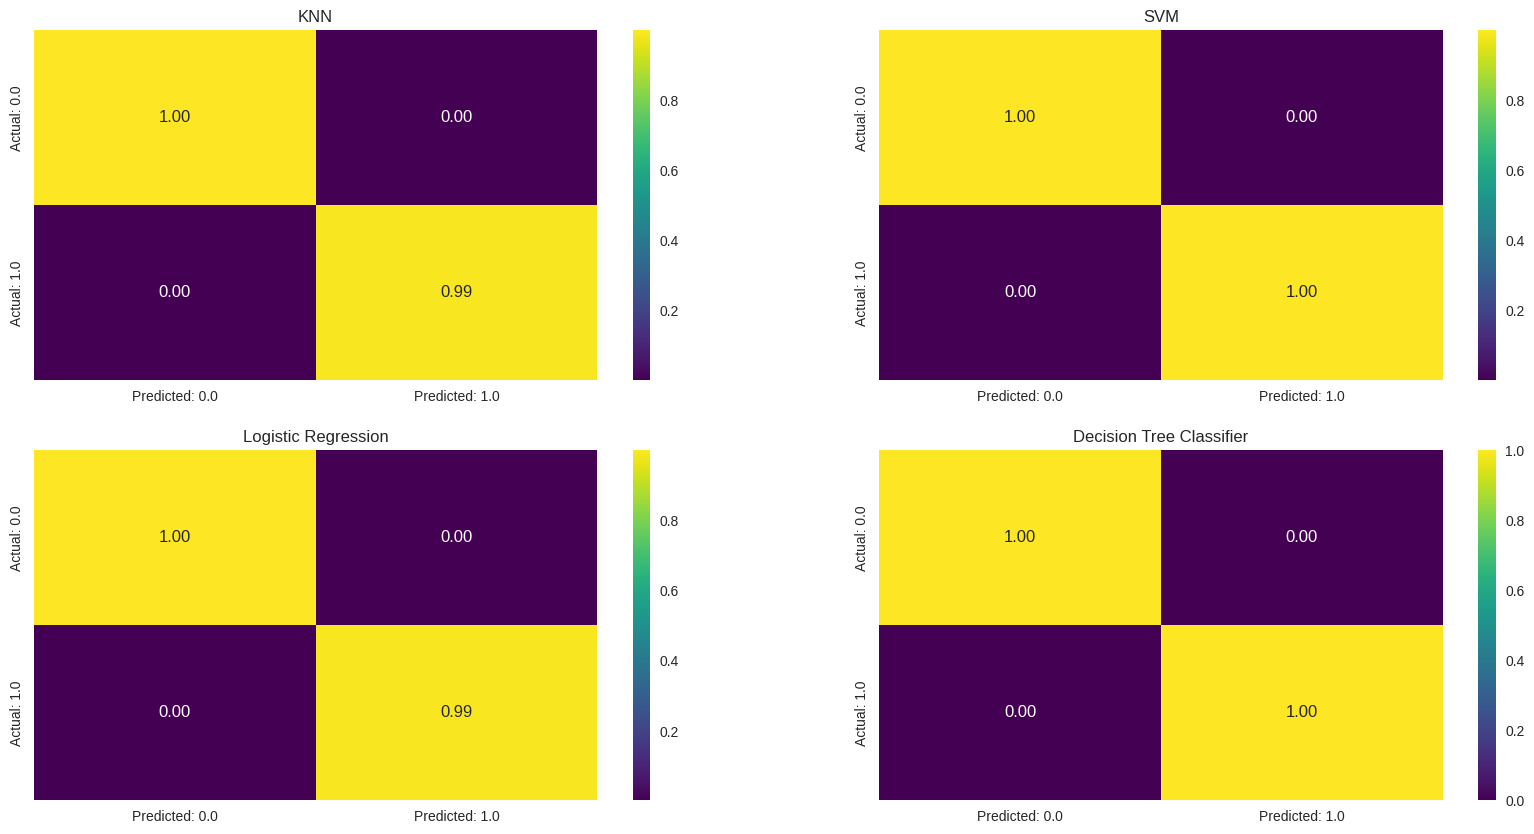

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(20,10))
axes[0][0].set_title('KNN')
axes[0][1].set_title('SVM')
axes[1][0].set_title('Logistic Regression')
axes[1][1].set_title('Decision Tree Classifier')
display_conf_matrix(cm_knn_train, axes[0][0])
display_conf_matrix(cm_svm_train, axes[0][1])
display_conf_matrix(cm_lr_train, axes[1][0])
display_conf_matrix(cm_dt_train, axes[1][1])

**5.1.2 Confusion Matrices For Validation Dataset**

<Axes: title={'center': 'Decision Tree Classifier'}>

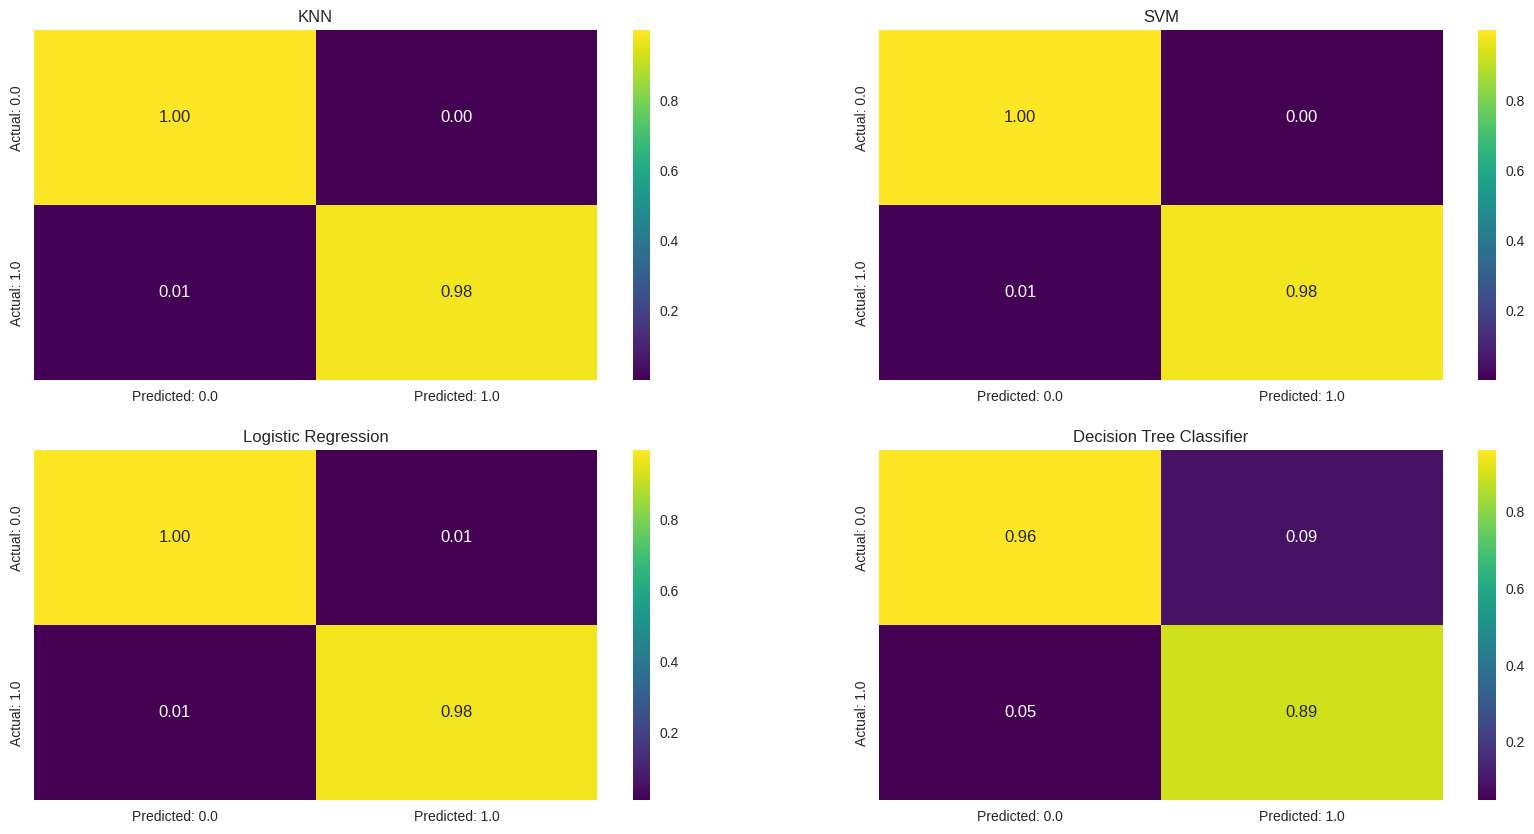

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(20,10))
axes[0][0].set_title('KNN')
axes[0][1].set_title('SVM')
axes[1][0].set_title('Logistic Regression')
axes[1][1].set_title('Decision Tree Classifier')
display_conf_matrix(cm_knn_valid, axes[0][0])
display_conf_matrix(cm_svm_valid, axes[0][1])
display_conf_matrix(cm_lr_valid, axes[1][0])
display_conf_matrix(cm_dt_valid, axes[1][1])

**5.3 Classification Scores**

We will calculate accuracy, precision, recall and F1 scores for our models. Then using pandas, we are going to create a table of the metrics for our models.




**Accuracy**: a widely used metric in machine learning that measures the percentage of correctly classified instances among all instances. It is calculated by dividing the number of correctly predicted instances by the total number of instances:

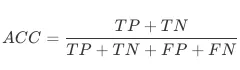

**Precision:** a metric that measures the percentage of correctly predicted positive instances out of all predicted positive instances. It is calculated by dividing the number of true positive instances by the sum of true positive and false positive instances:

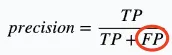

**Recall:** a metric that measures the percentage of correctly predicted positive instances out of all actual positive instances. It is calculated by dividing the number of true positive instances by the sum of true positive and false negative instances:

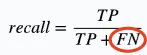

**F1-score:** F1-score is a metric that combines precision and recall into a single score that represents the harmonic mean of the two. The F1-score is useful when the distribution of positive and negative instances is imbalanced. It is calculated by the following:

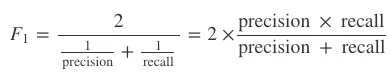

**Specificity:** is the proportion of true negatives that are correctly predicted by the model:

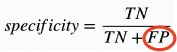


In [ ]:
#Calculates accuracy, precision, recall, f1 and specificity from a confusion matrix
def calc_scores(cm):
  tn, fp, fn, tp = cm.ravel()
  # calculate accuracy
  accuracy = (tp + tn) /  (tp + tn + fp + fn)
  # calculate precision
  precision = tp / (tp + fp)
  # calculate recall
  recall = tp / (tp + fn)
  # calculate f1 score
  f1 = 2 * (precision * recall) / (precision + recall)
  # calculate specificity
  specificity = tn / (tn + fp)
  return [accuracy, precision, recall, f1, specificity]

In [ ]:
#Define the accuracy, precision, recall and f1 scores from the confusion matrix for the training dataset
scores_knn_train = calc_scores(cm_knn_train)
scores_svm_train = calc_scores(cm_svm_train)
scores_lr_train = calc_scores(cm_lr_train)
scores_dt_train = calc_scores(cm_dt_train)

#Define the accuracy, precision, recall and f1 scores from the confusion matrix for the validation dataset
scores_knn_valid = calc_scores(cm_knn_valid)
scores_svm_valid = calc_scores(cm_svm_valid)
scores_lr_valid = calc_scores(cm_lr_valid)
scores_dt_valid = calc_scores(cm_dt_valid)

In [ ]:
# Define the model names and their scores for both training and validation set
models = {'KNN' : {'Accuracy (Train)' : scores_knn_train[0],
                  'Accuracy (Valid)' : scores_knn_valid[0],
                   'Precision (Train)' : scores_knn_train[1],
                   'Precision (Valid)' : scores_knn_valid[1],
                   'Recall (Train)' : scores_knn_train[2],
                  'Recall (Valid)' : scores_knn_valid[2],
                   'F1 (Train)' : scores_knn_train[3],
                   'F1 (Valid)' : scores_knn_valid[3],
                    'Specificity (Train)' : scores_knn_train[4],
                   'Specificity (Valid)' : scores_knn_valid[4]
                   },
          'SVM' : {'Accuracy (Train)' : scores_svm_train[0],
                  'Accuracy (Valid)' : scores_svm_valid[0],
                   'Precision (Train)' : scores_svm_train[1],
                   'Precision (Valid)' : scores_svm_valid[1],
                   'Recall (Train)' : scores_svm_train[2],
                  'Recall (Valid)' : scores_svm_valid[2],
                   'F1 (Train)' : scores_svm_train[3],
                   'F1 (Valid)' : scores_svm_valid[3],
                    'Specificity (Train)' : scores_svm_train[4],
                   'Specificity (Valid)' : scores_svm_valid[4]
                   },
          'LR' : {'Accuracy (Train)' : scores_lr_train[0],
                  'Accuracy (Valid)' : scores_lr_valid[0],
                   'Precision (Train)' : scores_lr_train[1],
                   'Precision (Valid)' : scores_lr_valid[1],
                   'Recall (Train)' : scores_lr_train[2],
                  'Recall (Valid)' : scores_lr_valid[2],
                   'F1 (Train)' : scores_lr_train[3],
                   'F1 (Valid)' : scores_lr_valid[3],
                    'Specificity (Train)' : scores_lr_train[4],
                   'Specificity (Valid)' : scores_lr_valid[4]
                   },
          'DT' : {'Accuracy (Train)' : scores_dt_train[0],
                  'Accuracy (Valid)' : scores_dt_valid[0],
                   'Precision (Train)' : scores_dt_train[1],
                   'Precision (Valid)' : scores_dt_valid[1],
                   'Recall (Train)' : scores_dt_train[2],
                  'Recall (Valid)' : scores_dt_valid[2],
                   'F1 (Train)' : scores_dt_train[3],
                   'F1 (Valid)' : scores_dt_valid[3],
                    'Specificity (Train)' : scores_dt_train[4],
                   'Specificity (Valid)' : scores_dt_valid[4]
                   }
          }
table = pd.DataFrame(models).T
table

,Accuracy (Train),Accuracy (Valid),Precision (Train),Precision (Valid),Recall (Train),Recall (Valid),F1 (Train),F1 (Valid),Specificity (Train),Specificity (Valid)
KNN,0.997783,0.995053,0.999521,0.998462,0.996031,0.991578,0.997773,0.995008,0.999525,0.998490
SVM,0.999391,0.995769,0.999905,0.999231,0.998876,0.992258,0.999390,0.995733,0.999905,0.999244
LR,0.995907,0.990467,0.996460,0.991551,0.995317,0.989187,0.995888,0.990368,0.996492,0.991724
DT,1.000000,0.931937,1.000000,0.909931,1.000000,0.950023,1.000000,0.929545,1.000000,0.915731


**Table 5.1** - Table of scores for accuracy, precision, recall, F1 and specificity for the training and validation dataset for all the models.

In [ ]:
print("Highest Scores")
print("---------------")
print(table.idxmax(axis=0))

Highest Scores
---------------
Accuracy (Train)        DT
Accuracy (Valid)       SVM
Precision (Train)       DT
Precision (Valid)      SVM
Recall (Train)          DT
Recall (Valid)         SVM
F1 (Train)              DT
F1 (Valid)             SVM
Specificity (Train)     DT
Specificity (Valid)    SVM
dtype: object


**5.4 Cross-Validation (CV) Scheme**

One way we could solve overfitting is using the Cross-validation (CV) scheme, one of the more common solutions being KFolds (Loukas 2023). Using a KFolds scheme, we wiil train and test each model k-times on different subsets of the training data and estimate a performance metric using each test data.



In [ ]:
def calc_valid_scores(model, X_train, y_train):
  scores = cross_val_score(model, X=X_train, y=y_train, cv=5, n_jobs=1)
  print('Cross Validation accuracy scores: %s' % scores)
  print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

In [ ]:
calc_valid_scores(knn, X_train, y_train)

Cross Validation accuracy scores: [0.99508528 0.99537372 0.99624115 0.99522915 0.99609657]
Cross Validation accuracy: 0.996 +/- 0.000


In [ ]:
calc_valid_scores(svm, X_train, y_train)

Cross Validation accuracy scores: [0.99508528 0.99667486 0.99739772 0.99754229 0.996964  ]
Cross Validation accuracy: 0.997 +/- 0.001


In [ ]:
calc_valid_scores(lr, X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:450: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  opt_res = optimize.minimize(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:450: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  opt_res = optimize.mi

Cross Validation accuracy scores: [0.99031512 0.99248229 0.99450629 0.99494    0.99320515]
Cross Validation accuracy: 0.993 +/- 0.002


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:450: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  opt_res = optimize.minimize(


In [ ]:
calc_valid_scores(dt, X_train, y_train)

Cross Validation accuracy scores: [0.93943336 0.93971375 0.94332803 0.94434003 0.94564117]
Cross Validation accuracy: 0.942 +/- 0.002


**5.4 Results Analysis**

Based on table 5.1, it is evident that the accuracy score for KNN and SVM models for the training dataset is slightly higher than their respective accuracy score for the validation dataset. However, the LR and DT models have much higher training accuracy score compared to its validation accuracy score. The results for precision, recall, f1, and specificity show a similar pattern, with the DT model having the highest scores for its training set but SVM having the highest scores for validation.Furthermore, the mean cross-validation score for the DT model is the lowest among all the other machine learning models.

These results suggest that the KNN, SVM, and LR models may have been slightly overfit, with SVM being the least overfit the highest cross validation mean. The DT model may scored the highest accuracy for the training dataset, but it has been significantly overfit compared to the other models. KNN and SVM are both non-parametric, while LR is linear and parametric. Decision trees, being a non-parametric and non-linear machine learning algorithm, are known to be highly flexible and have a high potential for overfitting the training data. WThis is expected since overfitting is more likely with non-parametric and non-linear models (Brownlee 2019).

In conclusion, since SVM has the highest accuracy score, in addition to being the least overfit, we can safely declare SVM (with parameters: C=0.1, gamma=0.1, kernel='poly') as the most efficient model to use for image classification.



## Extra Task

Complete the skeleton code gives you a solid foundation to build an effective face detection system. You are
encouraged to carry out more exploration from there and aim at creating a better face detection application. You
can either use taught or untaught techniques for this project. You are welcome to add new functions and improve
the source code. You can discuss the ideas if you have specific additions in mind.


**Detect Similar Faces**

We are going to detect similar faces using K-Means clustering.

In [ ]:
#Add your code here
from sklearn.cluster import KMeans
n_clusters = 40
kmeans = KMeans(n_clusters)

In [ ]:
kmeans.fit(X)
y = kmeans.predict(X)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
kmeans.cluster_centers_

array([[0.17908167, 0.14853971, 0.07711528, ..., 0.01678793, 0.01840233,
        0.02820426],
       [0.18060269, 0.13276582, 0.07906093, ..., 0.02881151, 0.03197119,
        0.04375083],
       [0.13072038, 0.07015479, 0.07302872, ..., 0.08419595, 0.07425207,
        0.07279742],
       ...,
       [0.14260241, 0.04644926, 0.0436819 , ..., 0.06055934, 0.07058927,
        0.11461855],
       [0.12122404, 0.05304106, 0.06943946, ..., 0.08798484, 0.05071122,
        0.03980359],
       [0.18600152, 0.04990927, 0.08896914, ..., 0.1114463 , 0.05777597,
        0.02749497]])

**Silhoutte Diagram**

We will now find the best K value for our model.

In [ ]:
!pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
k=40
kmeans = KMeans(n_clusters=k)
y = kmeans.fit_predict(X)
visModel = SilhouetteVisualizer(kmeans)
visModel.fit(X)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


NameError: ignored

In [ ]:
k=50
kmeans = KMeans(n_clusters=k)
y = kmeans.fit_predict(X)
visModel = SilhouetteVisualizer(kmeans)
visModel.fit(X)

**Display Similar Faces**



In [ ]:
idx = 1
samples_similar = X[y==idx]
samples_size = len(samples_similar)

In [ ]:
fig, axes = plt.subplots(4,4, figsize=(10,10))

for i in range(4):
  for j in range(4):
    digi_img = samples_similar.values[i*j].reshape(64,64)
    axes[i][j].imshow(digi_img,cmap=plt.cm.binary_r)
    axes[i][j].axis('off')

# 7. References

1. Cheryl. study notes: Handling Skewed data for Machine Learning models. 04 November 2020.
https://reinec.medium.com/my-notes-handling-skewed-data-5984de303725

2.   Gong, Destin. Top 6 Machine Learning Algorithms for Classification.” Medium, Towards Data Science, 12 July 2022. https://towardsdatascience.com/top-machine-learning-algorithms-for-classification-2197870ff501.

3.  Loukas, Serafeim. Is your model overfitting? Or maybe underfitting? An example using a neural network in python. 02 March 2023. https://towardsdatascience.com/is-your-model-overfitting-or-maybe-underfitting-an-example-using-a-neural-network-in-python-4faf155398d2#:~:text=common%20than%20underfitting.-,Overfitting%20is%20when%20the%20model's%20error%20on%20the%20training%20set,and%20testing)%20is%20very%20high.

4. Brownlee, Jason. Overfitting and Underfitting With Machine Learning Algorithms. 12 August 2019. https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/#:~:text=Overfitting%20is%20more%20likely%20with,much%20detail%20the%20model%20learns.






